# Gather statistics about iterative point position & tagger precision estimation procedue

Perform $N_e$ experiments, in which data is simulated and used for the estimation procedure:

Simulate points $x_j$, tags $x_{ji} \sim N(x_j,\sigma_i^2)$ for N points ($j=1,...,N$) and $N_t$ taggers ($i=1,...,N_t$).

Peform the estimation procedure, and gather data after convergence:
1. The MSE for the estimation of $x_j$ (using the estimated sigmas, the real sigmas, and an equal-weight average)
2. The MSE for the estimation of $\sigma_i$

Gather data for different $N_t$, $\beta$.

In [78]:
import numpy as np
from numpy import linalg as LA
import matplotlib.pyplot as plt
import scipy

### Define functions that 1. Simulate the data 2. Run the estimation procedure

In [2]:
def simulate_data(N,Nt):
    ''' Simulate ground truth points, tagger properties, and tags
    Args:
    N (int): The number of ground truth points to simulate
    Nt (ind): The number of taggers
    
    Returns:
    gt_pos: a (N,2) np.array with ground truth positions in 2D
    sigma_sq: a length Nt np.array containing sigma**2 of tagger i in index i
    clusters: length N array. clusters[i][0]: a list of taggers that tagged the i-th gt point,
    clusters[i][1]: the tags generated for the i-th gt point
    '''
    
    L = 100 # gt points will be in [0,L]x[0,L]
    
    # properties of taggers
    # draw the values of the pi's from a uniform distribution in [0,1]
    p = np.random.uniform(low=1, high=1, size=(Nt)) #p[i] is the detection probability of tagger i
    sigma_sq = np.random.uniform(low=0.5, high=3, size=(Nt))**2 # sigma_sq[i] is the var of position tagged by tagger i
    
    # draw ground truth position uniformly in [0,L] x [0,L]
    gt_pos = np.random.uniform(low=0,high=L,size=(N,2))
    
    # simulate tags for each of the clusters
    clusters = [None]*N # if there are no tags for gt point k, clusters[k] will remain None
    cluster_is_tagged = [False]*N # cluster_is_tagged[k]==True iff there is at least one tag for gt point k
    for k in range(N):
        is_tagged = [np.random.binomial(n=1,p=p[i]) for i in range(Nt)]
        tagged_ind = np.where(is_tagged)[0]
        # if no tags exist, don't save this cluster
        if any(is_tagged):
            #tagged_ind = list(range(Nt))
            tags = np.zeros((len(tagged_ind),2))
            for j,i in enumerate(tagged_ind): # loop over tags that exist
                # draw position from normal distribution
                tags[j,:] = np.random.multivariate_normal(mean=gt_pos[k,:],cov=sigma_sq[i]*np.identity(2))
            clusters[k] = (tagged_ind, tags)
            cluster_is_tagged[k] = True
    
    # only worked with tagged points - through away the untagged ones
    Neffective = sum(cluster_is_tagged) # the number of tagged gt points
    if Neffective<N:
        gt_pos = gt_pos[cluster_is_tagged,:]
        clusters = np.array(clusters)
        clusters = clusters[cluster_is_tagged]
    
    return sigma_sq, gt_pos, clusters

In [3]:
# given sigma_sq_est, estimate the gt position
def update_pos(clusters, sigma_sq_est, N, beta=0):
    # beta = regularization parameter to prevent weight divergence to infinity
    gt_pos_est = np.zeros((N,2))
    for k in range(N): # loop over clusters
        tagged_ind, tags = clusters[k]
        weights = np.expand_dims(1/(sigma_sq_est[tagged_ind]+beta), axis=-1)
        gt_pos_est[k,:] = np.sum(tags*weights,axis=0) / np.sum(weights)
    return gt_pos_est

def update_sigma_sq(clusters, gt_pos_est, N, Nt):
    # given estimated positions, estimate sigma_sq[i]
    # for each cluster, accumulate data for all tags that exist.
    # keep count of how many points have from each, then divide
    s = np.zeros(Nt) # s[i] = sum over (x-gt)**2 for tagger i (2D since have x,y)
    count = np.zeros(Nt) # count[i] = number of data points for tagger i
    for k in range(N): # loop over clusters
        tagged_ind, tags = clusters[k]
        gt_pos_est_k = gt_pos_est[k,:]
        shifted_tags = tags - gt_pos_est_k
        s[tagged_ind] += np.sum(shifted_tags**2, axis=1)
        count[tagged_ind] += 2 # summed samples (each point gives 1 sample for x, 1 for y)

    s = s / (count-1) # estimator of sigma squared
    # lower bound possible s values:
    #s_sq_min = 0.1
    #s[s<s_sq_min] = s_sq_min
    return s #sigma_sq_est

In [4]:
def estimate_positions_and_sigmas(N,Nt,clusters,beta):
    ''' Perform iterations to estimate the positions and sigmas.
    Args:
        clusters: length N array. clusters[i][0]: a list of taggers that tagged the i-th gt point,
            clusters[i][1]: the tags generated for the i-th gt point
        diff_thresh (float): a threshold for determining convergence
            (small number below which can say the algorithm converged)
        beta: regulrization parameter
    
    Returns:
        gt_pos_est, sigma_sq_est - estimates of gt positions, sigmas
    '''
    # set estimates to initial values
    #p_est = 0.7*np.ones(Nt)
    sigma_sq_est = 1*np.ones(Nt)
    gt_pos_est = np.zeros((N,2))
    
    diff_thresh = 1e-10
    counter = 0
    Nsteps_max= 1000 # if no convergence until reached, exit and display message

    # perform first step of gt and sigma estimation
    gt_pos_est_prev = gt_pos_est # save previous estimate
    gt_pos_est = update_pos(clusters, sigma_sq_est, N, beta=beta)
    sigma_sq_est = update_sigma_sq(clusters, gt_pos_est, N, Nt)

    while LA.norm(gt_pos_est - gt_pos_est_prev)>diff_thresh:
        gt_pos_est_prev = gt_pos_est
        gt_pos_est = update_pos(clusters, sigma_sq_est, N, beta=beta)
        sigma_sq_est = update_sigma_sq(clusters, gt_pos_est, N, Nt)

        counter += 1
        if counter==Nsteps_max:
            print('Exited without converging after ' + str(Nsteps_max) + ' steps.')
            break

        #print(counter, LA.norm(gt_pos_est - gt_pos_est_prev))
    #else:
        #print('Converged after ', counter, ' steps.')

    
    return gt_pos_est, sigma_sq_est

### Set parameters, initialize variables to collect results

In [110]:
#Ns = 1000 # number of repeats for each parameter value
Ns = 30
N = 2000 # number of points simulated in each instance
Nt = 3 # number of taggers
beta_list = np.arange(0,2,0.2)
#beta_list = np.array([0,0.25,0.5,0.75,1])
Nbeta = len(beta_list)

In [111]:
# beta = 1
# sigma_sq, gt_pos, clusters = simulate_data(N,Nt)
# gt_pos_est, sigma_sq_est = estimate_positions_and_sigmas(N,Nt,clusters,beta)

In [112]:
# collect stats
# initialize variables
min_sigma_sq = np.zeros((Ns,Nbeta))
pos_mse = np.zeros((Ns,Nbeta))
sigma_sq_mse = np.zeros((Ns,Nbeta))

pos_mse_real_sigma = np.zeros((Ns))
pos_mse_naive_average = np.zeros((Ns))

In [113]:
import time
t = time.time()

# for each instance of simulated data, perform the estimation with varying beta
for i in range(Ns):
    sigma_sq, gt_pos, clusters = simulate_data(N,Nt) # simulate data
    
    for j, beta in enumerate(beta_list):
        gt_pos_est, sigma_sq_est = estimate_positions_and_sigmas(N,Nt,clusters,beta) # perform estimation
        
        # collect stats about estimation result
        min_sigma_sq[i,j] = min(sigma_sq_est)

        SE_pos_est = np.sum((gt_pos_est - gt_pos)**2,axis=1)
        pos_mse[i,j] = np.mean(SE_pos_est)
        
        sigma_diff = sigma_sq - sigma_sq_est
        sigma_sq_mse[i,j] = np.mean(sigma_diff**2)
        
    # collect stats about instance of simulated data
    gt_pos_est_real_s = update_pos(clusters, sigma_sq, N)
    SE_real_s_est = np.sum((gt_pos_est_real_s - gt_pos)**2,axis=1)
    pos_mse_real_sigma[i] = np.mean(SE_real_s_est)

    gt_pos_est_equal_s = update_pos(clusters, np.ones(sigma_sq.shape), N)
    SE_equal_s_est = np.sum((gt_pos_est_equal_s - gt_pos)**2,axis=1)
    pos_mse_naive_average[i] = np.mean(SE_equal_s_est)

elapsed = time.time() - t
print(elapsed/60)

1869.244151353836


## plot results

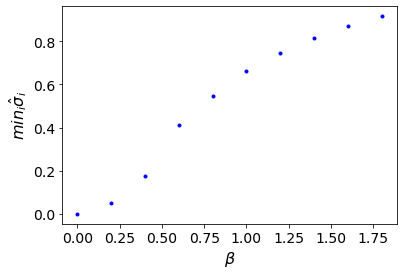

In [114]:
mean_min_sigma = np.mean(min_sigma_sq, axis=0) # mean over instances, as function of beta
plt.plot(beta_list,mean_min_sigma,'.b')
plt.xlabel('$\\beta$',fontsize=16)
plt.ylabel('$min_i \hat{\sigma}_i$',fontsize=16);
plt.xticks(fontsize=14)
plt.yticks(fontsize=14);

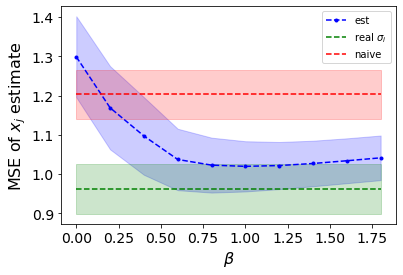

In [115]:
from scipy import stats

mean_pos_mse = np.mean(pos_mse,axis=0) # mean over Ns simulated data instances
mean_pos_mse_real_sigma = np.mean(pos_mse_real_sigma)
mean_pos_mse_naive_average = np.mean(pos_mse_naive_average)

std_pos_mse = np.std(pos_mse,axis=0) # mean over Ns simulated data instances
std_pos_mse_real_sigma = np.std(pos_mse_real_sigma)
std_pos_mse_naive_average = np.std(pos_mse_naive_average)

sem_pos_mse = scipy.stats.sem(pos_mse,axis=0) # mean over Ns simulated data instances
sem_pos_mse_real_sigma = scipy.stats.sem(pos_mse_real_sigma)
sem_pos_mse_naive_average = scipy.stats.sem(pos_mse_naive_average)

plt.figure()
h = [None]*3
h[0], = plt.plot(beta_list,mean_pos_mse,'.--b')
h[1], = plt.plot(beta_list,np.ones(len(beta_list))*mean_pos_mse_real_sigma,'--g')
h[2], = plt.plot(beta_list,np.ones(len(beta_list))*mean_pos_mse_naive_average,'--r')

plt.fill_between(beta_list, mean_pos_mse - sem_pos_mse, mean_pos_mse + sem_pos_mse, color='blue', alpha=0.2)
#plt.errorbar(beta_list,mean_pos_mse,sem_pos_mse)
plt.fill_between(beta_list, np.ones(len(beta_list))*mean_pos_mse_real_sigma - np.ones(len(beta_list))*sem_pos_mse_real_sigma, np.ones(len(beta_list))*mean_pos_mse_real_sigma + np.ones(len(beta_list))*sem_pos_mse_real_sigma, color='green', alpha=0.2)
plt.fill_between(beta_list, np.ones(len(beta_list))*mean_pos_mse_naive_average - np.ones(len(beta_list))*sem_pos_mse_naive_average, np.ones(len(beta_list))*mean_pos_mse_naive_average + np.ones(len(beta_list))*sem_pos_mse_naive_average, color='red', alpha=0.2)

plt.xlabel('$\\beta$',fontsize=16)
plt.ylabel('MSE of $x_j$ estimate',fontsize=16);
plt.xticks(fontsize=14)
plt.yticks(fontsize=14);
plt.legend(h, ('est','real $\sigma_i$','naive'));

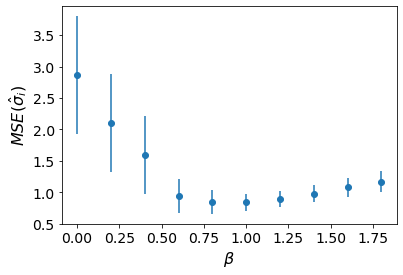

In [116]:
mean_sigma_sq_mse = np.mean(sigma_sq_mse, axis=0) # mean over instances, as function of beta
sem_sigma_sq_mse = scipy.stats.sem(sigma_sq_mse, axis=0) # mean over instances, as function of beta

#plt.plot(beta_list,mean_sigma_sq_mse,'.b')
plt.errorbar(beta_list,mean_sigma_sq_mse,sem_sigma_sq_mse,fmt='o')
plt.xlabel('$\\beta$',fontsize=16)
plt.ylabel('$MSE (\hat{\sigma}_i)$',fontsize=16);
plt.xticks(fontsize=14)
plt.yticks(fontsize=14);